### https://github.com/dsgissin/DiscriminativeActiveLearning/

In [30]:
from models import get_discriminative_model
from models import train_discriminative_model

# Source: https://github.com/dsgissin/DiscriminativeActiveLearning/
class QueryMethod:
    """
    A general class for query strategies, with a general method for querying examples to be labeled.
    """

    def __init__(self, model, input_shape=(28,28), num_labels=10, gpu=1):
        self.model = model
        self.input_shape = input_shape
        self.num_labels = num_labels
        self.gpu = gpu

    def query(self, X_train, Y_train, labeled_idx, amount):
        """
        get the indices of labeled examples after the given amount have been queried by the query strategy.
        :param X_train: the training set
        :param Y_train: the training labels
        :param labeled_idx: the indices of the labeled examples
        :param amount: the amount of examples to query
        :return: the new labeled indices (including the ones queried)
        """
        return NotImplemented

    def update_model(self, new_model):
        del self.model
        gc.collect()
        self.model = new_model

import numpy as np
def get_unlabeled_idx(X_train, labeled_idx):
    """
    Given the training set and the indices of the labeled examples, return the indices of the unlabeled examples.
    """
    return np.arange(X_train.shape[0])[np.logical_not(np.in1d(np.arange(X_train.shape[0]), labeled_idx))]


from scipy.spatial import distance_matrix

from keras.models import Model
import keras.backend as K
from keras.losses import categorical_crossentropy
from keras.layers import Lambda
from keras import optimizers
import gc

## Approach 1 - Discriminative Representation Active Learning

In [31]:
class DiscriminativeRepresentationSampling(QueryMethod):
    """
    An implementation of DAL (discriminative active learning), using the learned representation as our representation.
    This implementation is the one which performs best in practice.
    """

    def __init__(self, model, input_shape, num_labels, gpu):
        super().__init__(model, input_shape, num_labels, gpu)
        self.sub_batches = 2
        self.gpu = None


    def query(self, X_train, Y_train, labeled_idx, amount):
        print("querying")
        # subsample from the unlabeled set:
        unlabeled_idx = get_unlabeled_idx(X_train, labeled_idx)
        unlabeled_idx = np.random.choice(unlabeled_idx, np.min([labeled_idx.shape[0]*10, unlabeled_idx.size]), replace=False)

        representation = X_train

        # iteratively sub-sample using the discriminative sampling routine:
        labeled_so_far = 0
        sub_sample_size = int(amount / self.sub_batches)
        while labeled_so_far < amount:
            if labeled_so_far + sub_sample_size > amount:
                sub_sample_size = amount - labeled_so_far

            model = train_discriminative_model(representation[labeled_idx], representation[unlabeled_idx], representation[0].shape, gpu=self.gpu)
            print(representation[unlabeled_idx].shape)
            predictions = model.predict_proba(representation[unlabeled_idx])
            prob_component_1 = predictions[:, 1]
            #selected_indices = np.argpartition(predictions[:,1], -sub_sample_size)[-sub_sample_size:]
            selected_indices = np.argsort(prob_component_1)[-sub_sample_size:]
            labeled_idx = np.hstack((labeled_idx, unlabeled_idx[selected_indices]))
            labeled_so_far += sub_sample_size
            unlabeled_idx = get_unlabeled_idx(X_train, labeled_idx)
            unlabeled_idx = np.random.choice(unlabeled_idx, np.min([labeled_idx.shape[0]*10, unlabeled_idx.size]), replace=False)

            # delete the model to free GPU memory:
            del model
            gc.collect()
        gc.collect()

        return labeled_idx


In [43]:
import numpy as np
X_train = np.load("X_train.npy")
y_train = np.load("labels_train.npy")

In [44]:
drsampling = DiscriminativeRepresentationSampling(None, None, None, None)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from predict import binarize
labels_train = y_train
log_reg = LogisticRegression(C = 12.5) 
y = binarize(labels_train)
log_reg.fit(X_train, y)
sorted_feature_indices = np.argsort(log_reg.coef_[0])[::-1] # get the indices of the most important features in descending order

In [45]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

pca = PCA(n_components=3, svd_solver = 'auto') 
indices = sorted_feature_indices[:79]
X_train_pca = pca.fit_transform(X_train[:, indices])

In [ ]:
from sklearn.metrics import accuracy_score
accs = []
al_steps  = range(10, 150, 1)
for el in al_steps:
    indices = drsampling.query(X_train_pca, y_train, np.array([0]), el)
    param_grid = {
            'n_neighbors': [1, 2, 3, 5, 11, 15, 21, 31, 41, 51],
            'p': [1, 2] # 1 = manhattan, 2 = euclidean
        }
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_pca[indices, :], y[indices])
    predictions = grid_search.predict(X_train_pca)
    # Calculate the accuracy of the predictions
    accuracy = accuracy_score(y, predictions)
    accs.append(accuracy)

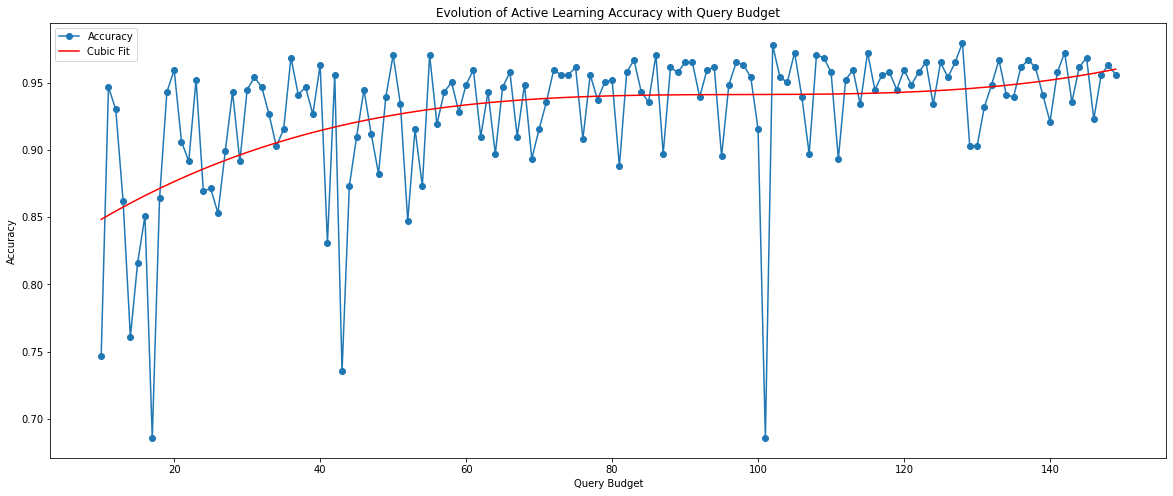

In [64]:
# Fit a quadratic polynomial (degree 2) to the data
x_axis = list(al_steps)[0:150]
coefficients = np.polyfit(x_axis, accs[:150], 3)
polynomial = np.poly1d(coefficients)

# Generate y-values for the polynomial at each x-value
y_poly = polynomial(x_axis)

# Create the plot
plt.figure(figsize=(20, 8))
plt.plot(x_axis, accs[:150], marker='o', label='Accuracy')
plt.plot(x_axis, y_poly, linestyle='-', color='red', label='Cubic Fit')
plt.title('Evolution of Active Learning Accuracy with Query Budget')
plt.xlabel('Query Budget')
plt.ylabel('Accuracy')
plt.legend()
#plt.gca().set_yscale("log")
#plt.grid(True)
plt.show()